In [83]:
from lsst.daf.butler import Butler
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [56]:
REPO = "/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
OUTPUT_COLL = "u/kmrakovc/single_frame_injection_01"
# Instantiate a butler.
butler = Butler(REPO)

In [96]:
injection_catalog = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=OUTPUT_COLL, instrument='HSC'))
butler.get(
        "injected_postISRCCD_catalog",
        dataId=injection_catalog[0].dataId,
        collections=OUTPUT_COLL,
    )

<Table length=21>
injection_id injection_flag injection_draw_size ...        beta        visit
   int64         int64             int64        ...      float64       int64
------------ -------------- ------------------- ... ------------------ -----
           0              0                  64 ...  78.26690252664388   322
           2              0                  28 ...  10.64103684601065   322
           4              0                  46 ... 0.1697209956593837   322
           5              0                  72 ...  67.33603307598919   322
           6              0                  88 ...  37.94408455235992   322
           7              0                  98 ... 32.212964706810425   322
           8              0                 122 ...  77.51996317641833   322
           9              0                 118 ...  43.84891038062954   322
          10              0                 138 ... 20.590197742981246   322
          11              0                  42 ... 39.539555770311885   322
          12              0                  34 ... 2.8469411450426287   322
          13              0                 136 ...  79.93045263412951   322
          14              0                  96 ...   75.6430752174433   322
          15              0                 142 ...  33.24579681343039   322
          16              0                 122 ...  71.34962595663434   322
          17              0                  46 ... 24.311008800970406   322
          18              0                  46 ...  72.68353474195271   322
          19              0                  64 ...  70.33115175128876   322
           1              0                 132 ...  28.99307808599235   322
           3              0                 150 ...  72.26471561794175   322
         776              8                 116 ... 53.473407603249065   322

In [77]:
catalog = butler.get(
        "injected_postISRCCD_catalog",
        dataId=injection_catalog[0].dataId,
        collections=OUTPUT_COLL,
    )


150.16415112917346

In [65]:
injected_calexp = []
calexp = []
registry = butler.registry
length = len(list(registry.queryDatasets("injected_calexp", collections=OUTPUT_COLL, instrument='HSC')))
for i,ref in enumerate(registry.queryDatasets("injected_calexp", collections=OUTPUT_COLL, instrument='HSC')):
    injected_calexp.append(butler.get(
        "injected_calexp",
        dataId=ref.dataId,
        collections=OUTPUT_COLL,
    ))
    calexp.append(butler.get(
        "calexp",
        dataId=ref.dataId,
        collections=OUTPUT_COLL,
    ))
    print("\r",i+1, "/", length, end="")

 234 / 234

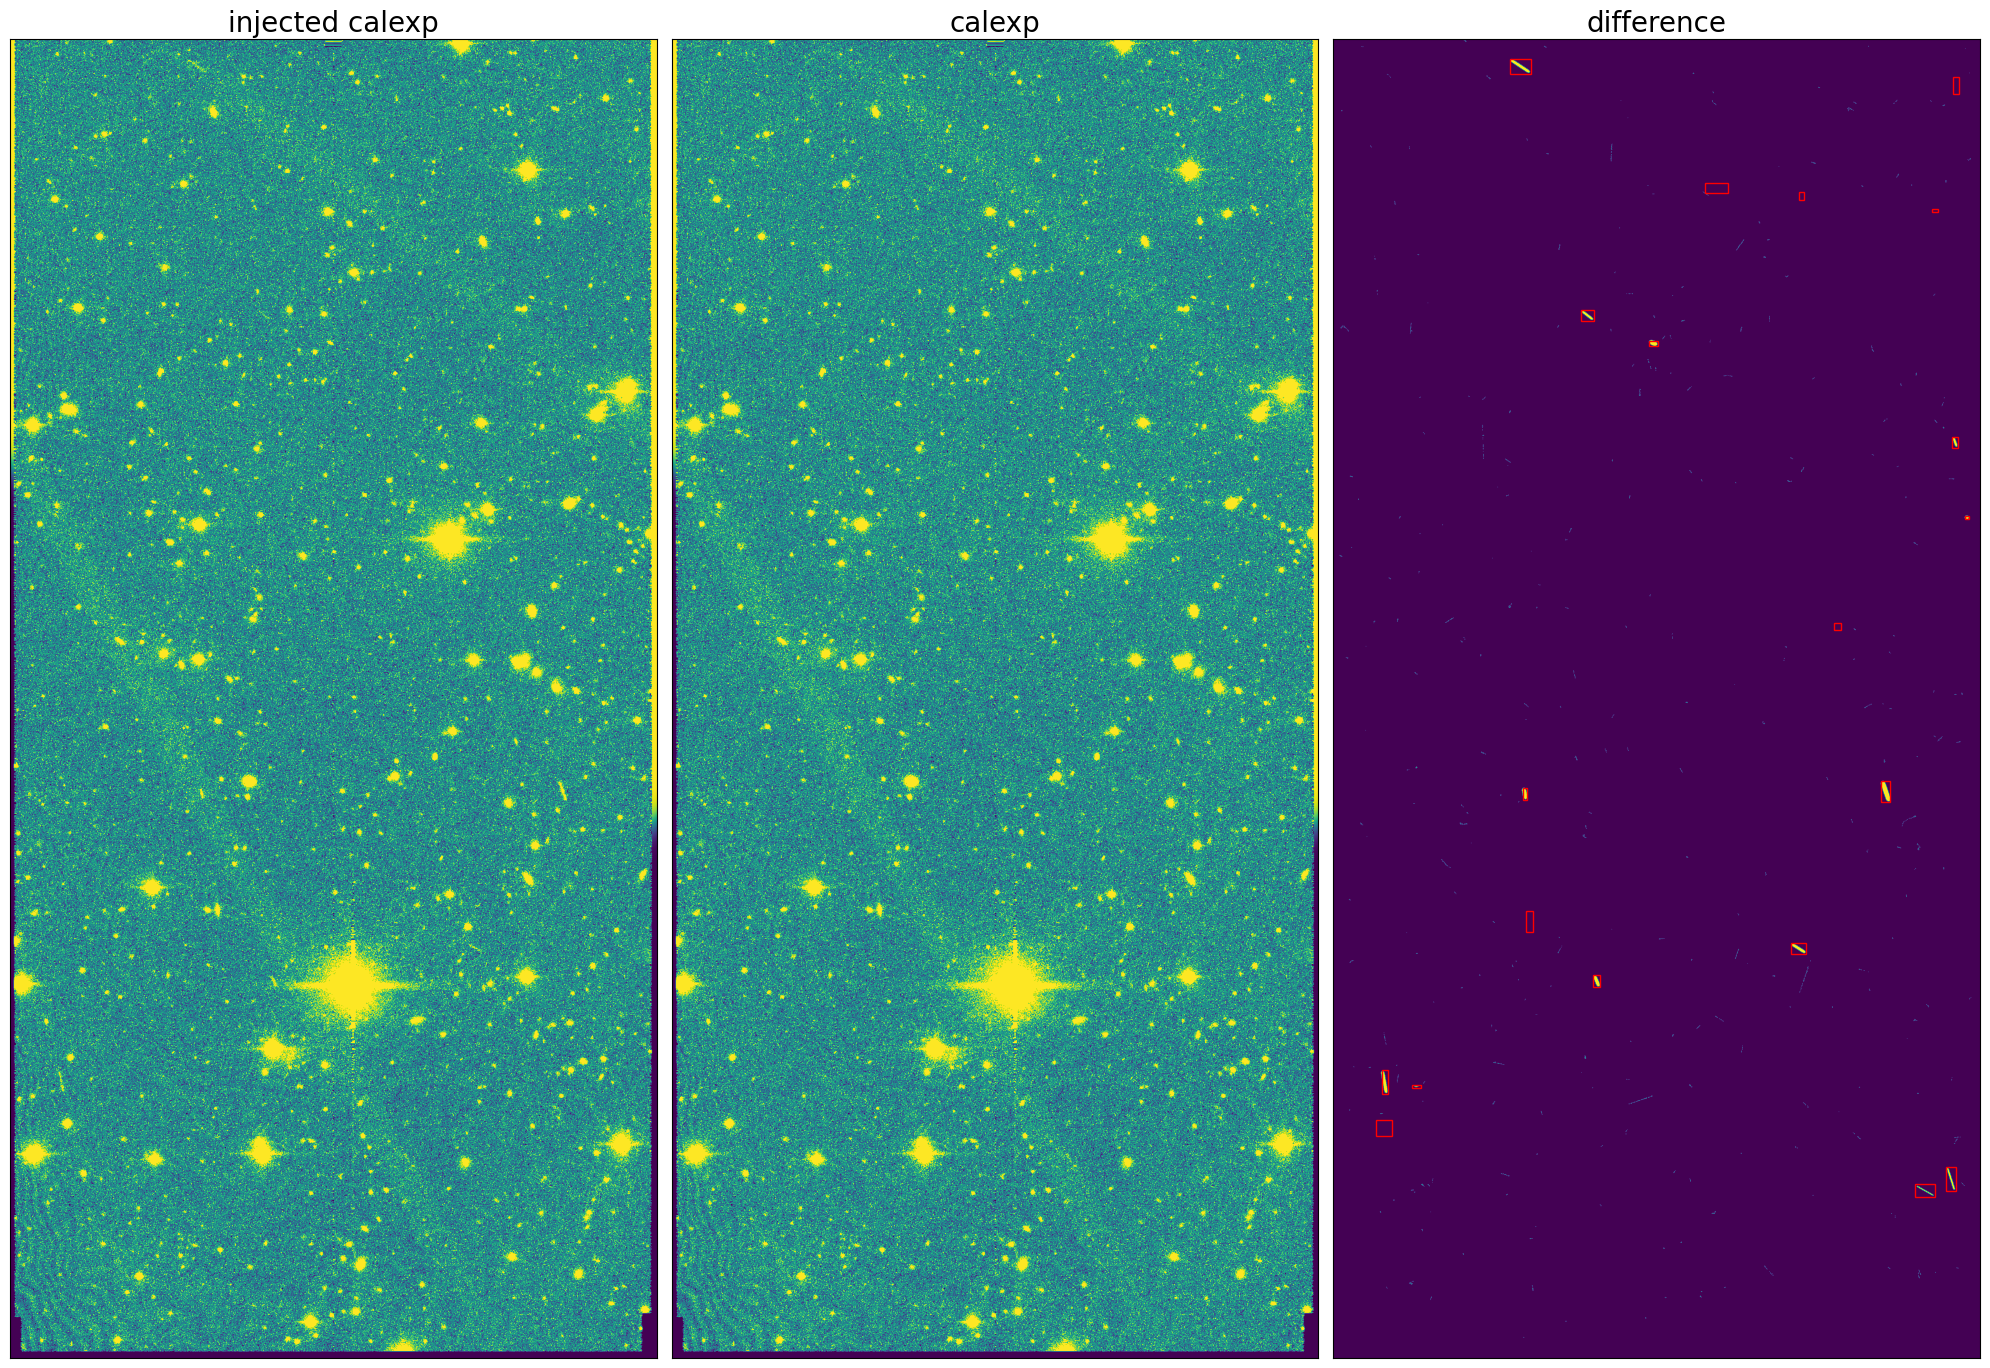

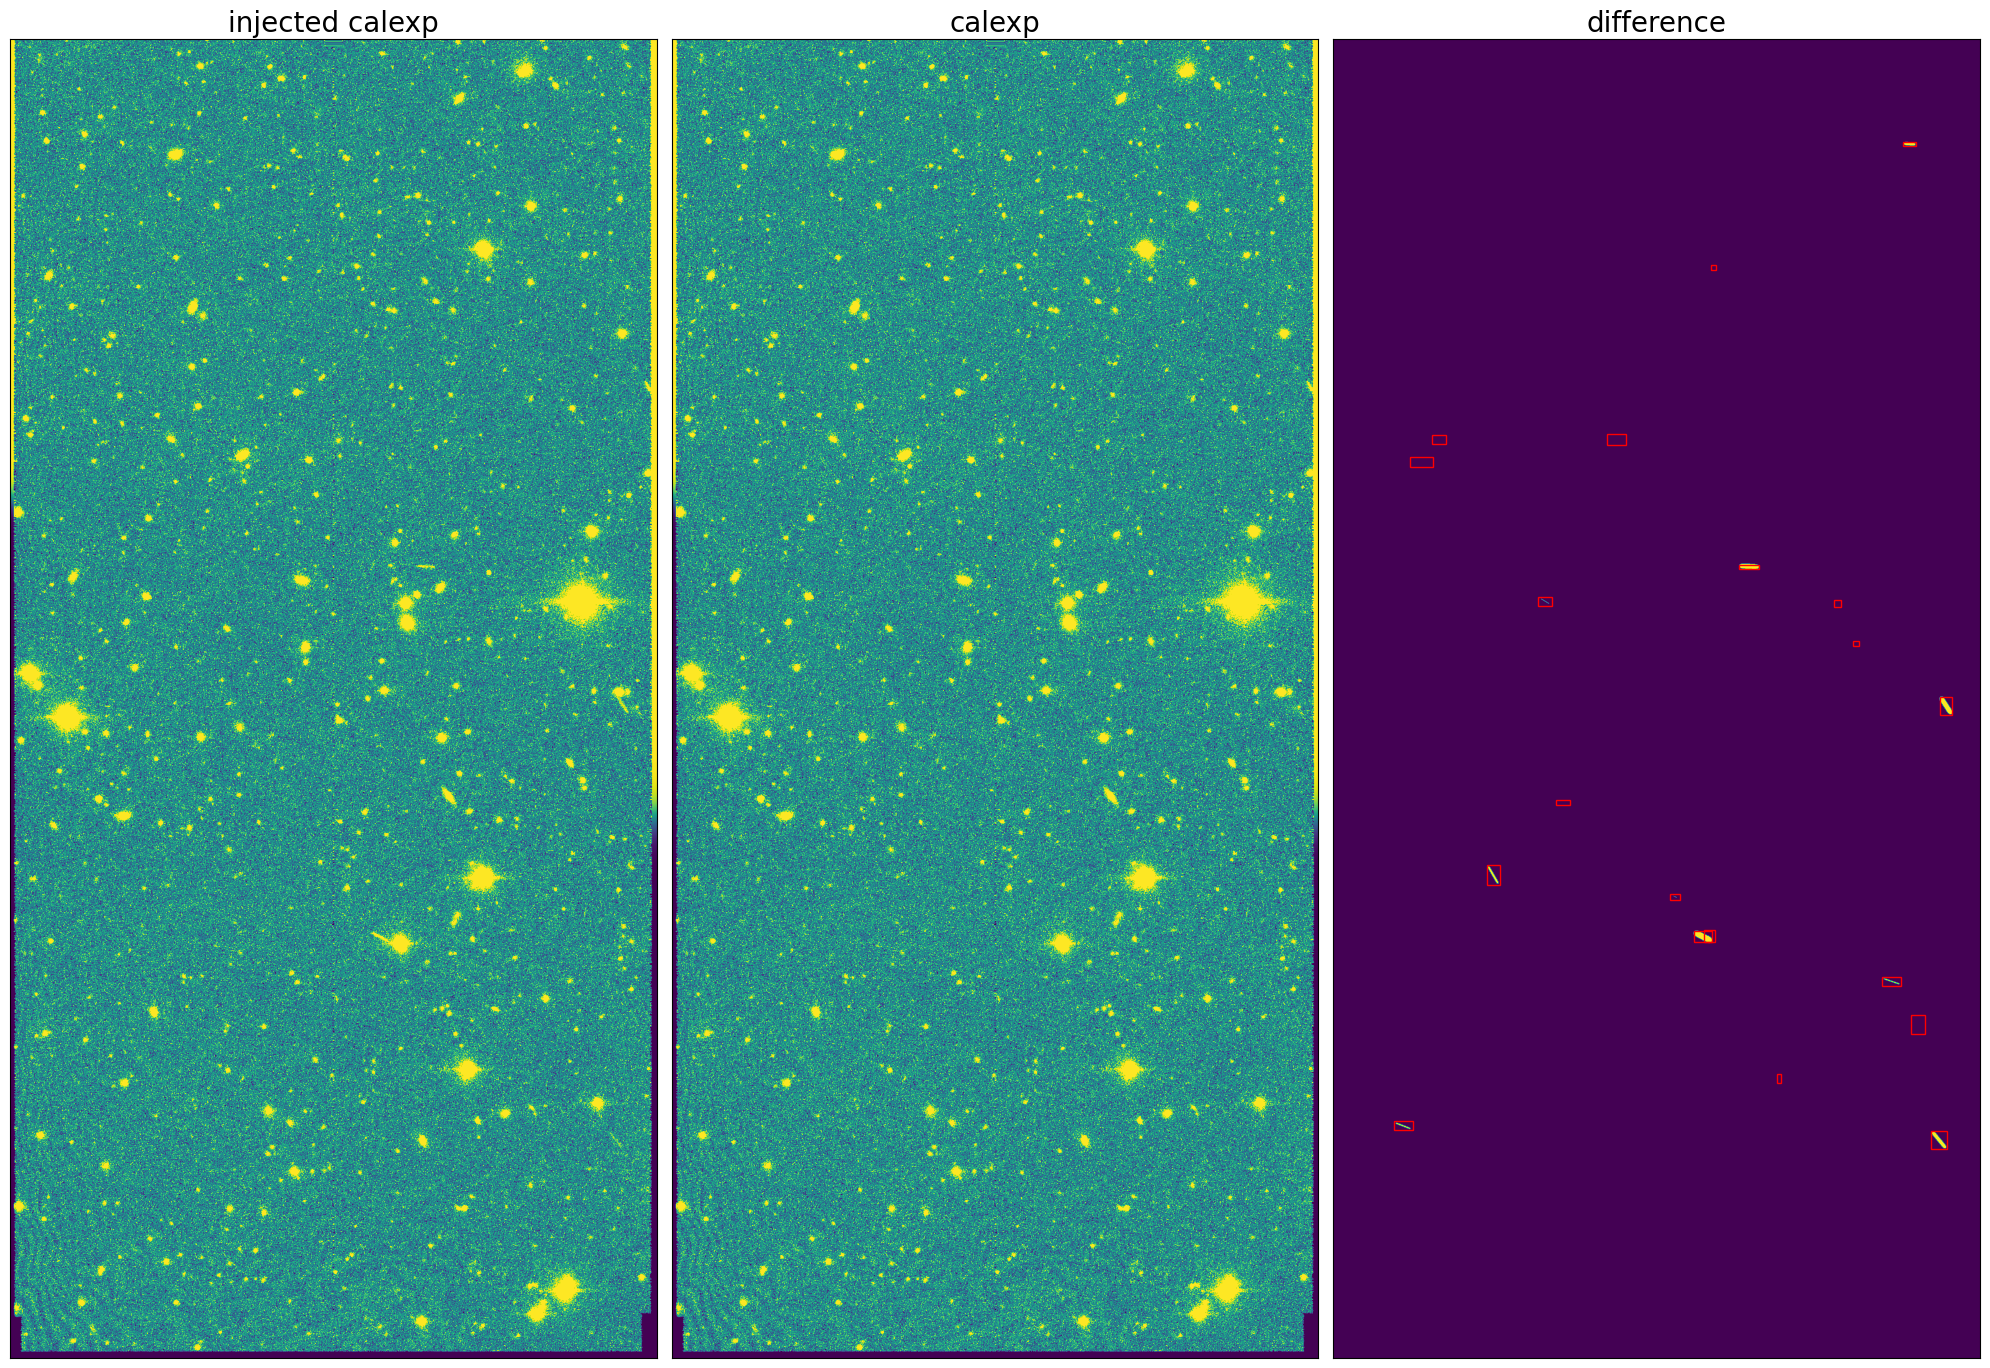

In [112]:
for i in range(2):# (len(calexp)):
    fig, ax = plt.subplots(1,3, figsize=(20,20))
    mask = injected_calexp[i].image.array-calexp[i].image.array
    mask = (mask > (mask.mean()+5*mask.std()))
    ax[0].imshow(np.tanh(injected_calexp[i].image.array))
    ax[1].imshow(np.tanh(calexp[i].image.array))
    #ax[2].imshow(injected_calexp[i].image.array-calexp[i].image.array)
    ax[2].imshow(mask)
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[2].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    ax[2].set_yticks([])
    ax[0].set_title("injected calexp", size = 20)
    ax[1].set_title("calexp", size = 20)
    ax[2].set_title("difference", size = 20)
    catalog = butler.get(
        "injected_postISRCCD_catalog",
        dataId=injection_catalog[i].dataId,
        collections=OUTPUT_COLL,
    )
    for k in range (len(catalog)):
        x0, y0 = injected_calexp[i].getWcs().skyToPixelArray(np.array([catalog[k]["ra"]]), np.array([catalog[k]["dec"]]), degrees=True)
        size_x = max([4,np.ceil(4+(catalog[k]["trail_length"]*np.cos((np.pi/180)*catalog[k]["beta"]))/2)])
        size_y = max([4,np.ceil(4+(catalog[k]["trail_length"]*np.sin((np.pi/180)*catalog[k]["beta"]))/2)])
        x0 = x0-size_x
        y0= y0-size_y
        rect = patches.Rectangle((x0, y0), 2*size_x, 2*size_y, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax[2].add_patch(rect)
    fig.tight_layout()
    plt.show()

In [51]:
def split(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    if arr.shape[0] % nrows != 0:
        arr = np.vstack([arr, np.zeros(shape = (nrows -(arr.shape[0]%nrows), arr.shape[1]))])
    if arr.shape[1] % ncols != 0:
        arr = np.hstack([arr, np.zeros(shape = (arr.shape[0], ncols-(arr.shape[1]%ncols)))])
    return (arr.reshape(arr.shape[0]//nrows, nrows, -1, ncols).swapaxes(1,2).reshape(-1, nrows, ncols))

In [52]:
mask = injected_calexp[0].image.array-calexp[0].image.array
mask = (mask > (mask.mean()+5*mask.std()))
split_injected_calexp = split (injected_calexp[0].image.array, 512, 512)
split_calexp = split (calexp[0].image.array, 512, 512)
split_mask = split (mask, 512, 512)

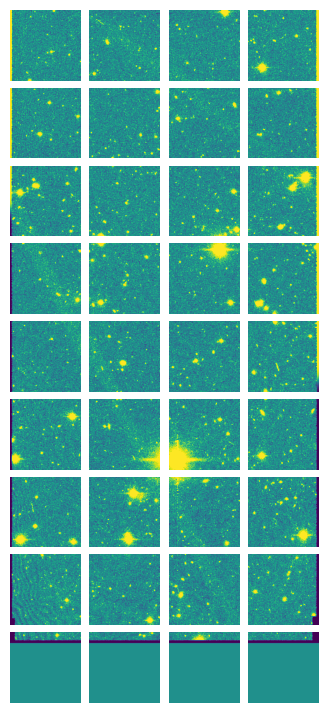

In [53]:
row = int(np.ceil(injected_calexp[0].image.array.shape[0]/512))
column = int(np.ceil(injected_calexp[0].image.array.shape[1]/512))
fig, ax = plt.subplots(row,column,figsize=(column, row))
for r in range(row):
    for c in range(column):
        ax[r,c].imshow(np.tanh(split_injected_calexp[r*column+c,:,:]))
        ax[r,c].axis('off')
        #ax[r,c].set_xticks([])
        #ax[r,c].set_yticks([])
fig.subplots_adjust(wspace=0.1, hspace=0.1)

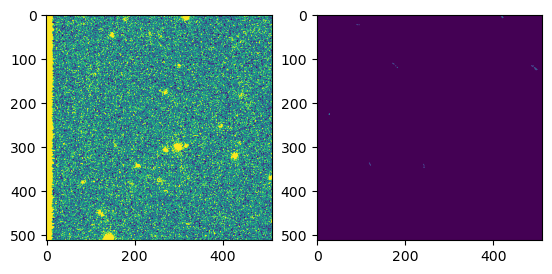

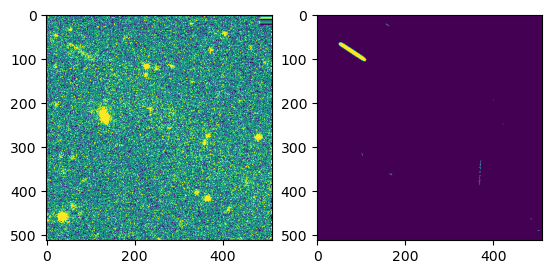

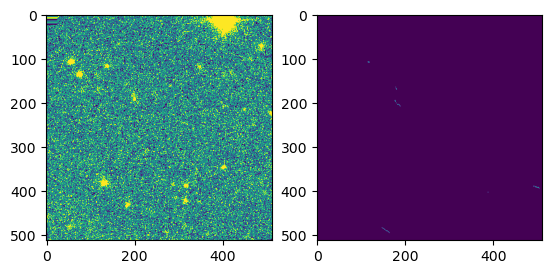

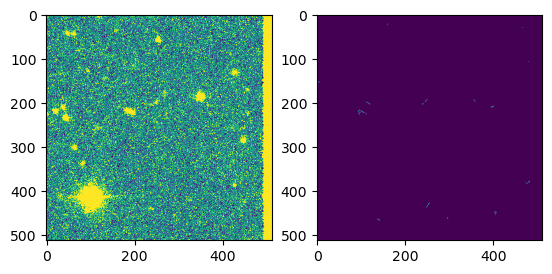

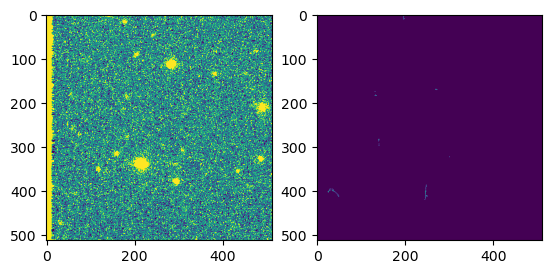

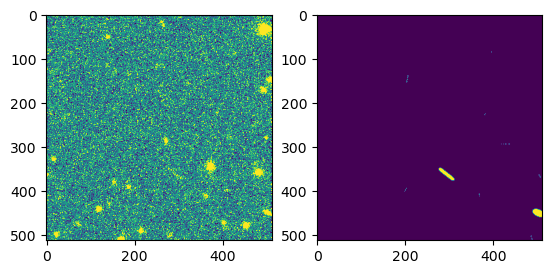

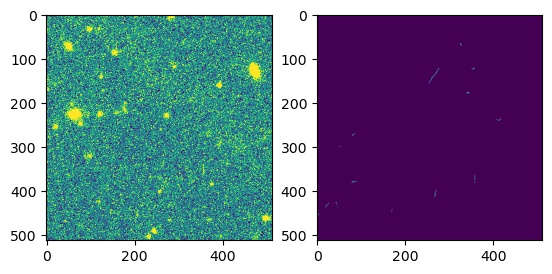

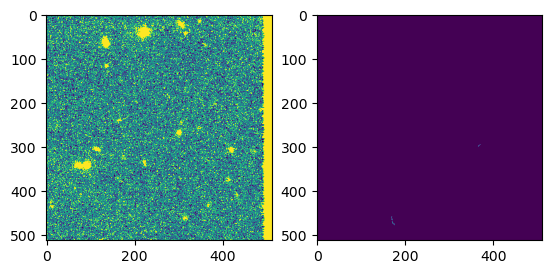

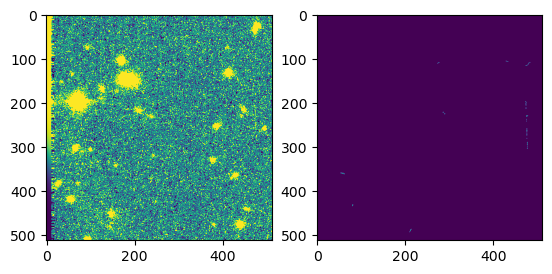

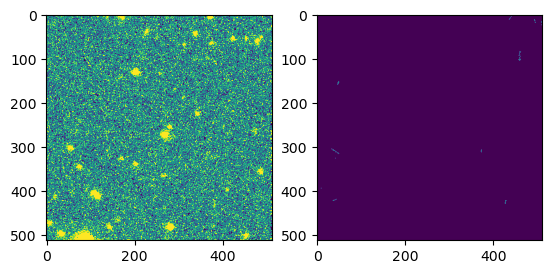

In [ ]:
for i in range(split_injected_calexp.shape[0]):
    if np.any(split_mask[i,:,:]):
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(np.tanh(split_injected_calexp[i,:,:]))
        ax[1].imshow(split_mask[i,:,:])
        plt.show()

In [17]:
injected_calexp[0].wcs.getPixelScale().asRadians()

8.166382702504654e-07